# Pride & Prejudice analysis

# Real text analysis

We got familiar with Spacy. In the next section we are going to analyse a real text (Pride & Prejudice). 

We would like to:
* Extract the names of all the characters from the book (e.g. Elizabeth, Darcy, Bingley)
* Visualize characters' occurences with regards to relative position in the book
* Authomatically describe any character from the book
* Find out which characters have been mentioned in a context of marriage
* Build keywords extraction that could be used to display a word cloud ([example](http://www.cytora.com/data-samples.html))

## Load text file

In [4]:
def read_file(file_name):
    with open(file_name, 'r') as file:
        return file.read()

## Process full text

In [5]:
import spacy

nlp = spacy.load('en_core_web_md')

# Process `text` with Spacy NLP Parser
text = read_file('data/pride_and_prejudice.txt')
processed_text = nlp(text)

In [6]:
# How many sentences are in the book (Pride & Prejudice)?
sentences = [s for s in processed_text.sents]
print(len(sentences))

# Print sentences from index 10 to index 15, to make sure that we have parsed the correct book
print(sentences[10:15])

6817
[*, *, * START OF, THIS PROJECT GUTENBERG EBOOK, PRIDE AND PREJUDICE]


## Find all the personal names

In [7]:
# Extract all the personal names from Pride & Prejudice and count their occurrences. 
# Expected output is a list in the following form: [('elizabeth', 622), ('darcy', 312), ('jane', 286), ('bennet', 266) ...].

from collections import Counter, defaultdict

def find_character_occurences(doc):
    """
    Return a list of actors from `doc` with corresponding occurences.
    
    :param doc: Spacy NLP parsed document
    :return: list of tuples in form
        [('elizabeth', 622), ('darcy', 312), ('jane', 286), ('bennet', 266)]
    """
    
    characters = Counter()
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            characters[ent.lemma_] += 1
            
    return characters.most_common()

print(find_character_occurences(processed_text)[:20])

[('elizabeth', 620), ('darcy', 303), ('jane', 285), ('bennet', 259), ('bingley', 205), ('wickham', 180), ('collins', 177), ('lydia', 163), ('lizzy', 94), ('gardiner', 92), ('lady catherine', 74), ('kitty', 71), ('longbourn', 38), ('mary', 37), ('william', 34), ('', 32), ('hurst', 32), ('phillips', 31), ('miss bingley', 25), ('forster', 23)]


## Plot characters personal names as a time series 

In [9]:
# Matplotlib Jupyter HACK
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Plot characters' mentions as a time series relative to the position of the actor's occurrence in a book.

def get_character_offsets(doc):
    """
    For every character in a `doc` collect all the occurences offsets and store them into a list. 
    The function returns a dictionary that has actor lemma as a key and list of occurences as a value for every character.
    
    :param doc: Spacy NLP parsed document
    :return: dict object in form
        {'elizabeth': [123, 543, 4534], 'darcy': [205, 2111]}
    """
    
    character_offsets = defaultdict(list)
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            character_offsets[ent.lemma_].append(ent.start)
            
    return dict(character_offsets)

character_occurences = get_character_offsets(processed_text)

/usr/local/miniconda3/envs/spacy-tut/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


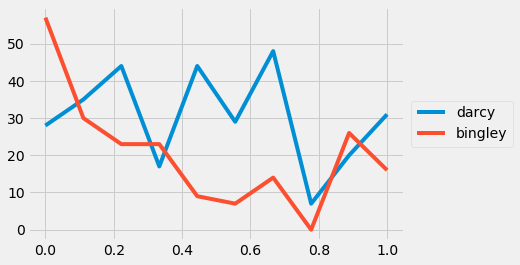

In [11]:
from matplotlib.pyplot import hist
from cycler import cycler

NUM_BINS = 10

def normalize(occurencies, normalization_constant):
    return [o / float(len(processed_text)) for o in occurencies]

def plot_character_timeseries(character_offsets, character_labels, normalization_constant=None):
    """
    Plot characters' personal names specified in `character_labels` list as time series.
    
    :param character_offsets: dict object in form {'elizabeth': [123, 543, 4534], 'darcy': [205, 2111]}
    :param character_labels: list of strings that should match some of the keys in `character_offsets`
    :param normalization_constant: int
    """
    x = [character_offsets[character_label] for character_label in character_labels] 
        
    with plt.style.context('fivethirtyeight'):
        plt.figure()
        n, bins, patches = plt.hist(x, NUM_BINS, label=character_labels)
        plt.clf()
        
        ax = plt.subplot(111)
        for i, a in enumerate(n):
            ax.plot([float(x) / (NUM_BINS - 1) for x in range(len(a))], a, label=character_labels[i])
            
        matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['r','k','c','b','y','m','g','#54a1FF'])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plot_character_timeseries(character_occurences, ['darcy', 'bingley'], normalization_constant=len(processed_text))
plot_character_timeseries(character_occurences, ['darcy', 'bingley'])

## Spacy parse tree in action

In [12]:
# Find words (adjectives) that describe Mr. Darcy.

def get_character_adjectives(doc, character_lemma):
    """
    Find all the adjectives related to `character_lemma` in `doc`
    
    :param doc: Spacy NLP parsed document
    :param character_lemma: string object
    :return: list of adjectives related to `character_lemma`
    """
    
    adjectives = []
    for ent in doc.ents:
        if ent.lemma_ == character_lemma:
            for token in ent.subtree:
                if token.pos_ == 'ADJ': # Replace with if token.dep_ == 'amod':
                    adjectives.append(token.lemma_)
    
    for ent in doc.ents:
        if ent.lemma_ == character_lemma:
            if ent.root.dep_ == 'nsubj':
                for child in ent.root.head.children:
                    if child.dep_ == 'acomp':
                        adjectives.append(child.lemma_)
    
    return adjectives

print(get_character_adjectives(processed_text, 'darcy'))

['grave', '-PRON-', '-PRON-', 'late', 'late', 'late', 'bad', 'late', 'intimate', 'confidential', 'present', '-PRON-', '-PRON-', '-PRON-', 'unappeasable', 'whose', '-PRON-', 'opposite', 'late', 'present', 'abominable', 'late', 'poor', 'handsome', '-PRON-', 'last', '-PRON-', '-PRON-', 'which', '-PRON-', 'little', '-PRON-', 'little', '-PRON-', 'clever', 'worth', 'little', 'grow', 'delighted', 'sorry', 'unworthy', 'answerable', 'impatient', 'ashamed', 'kind', 'proud', 'tall', 'punctual', 'engaged', 'delighted']


In [13]:
# Find characters that are 'talking', 'saying', 'doing' the most. Find the relationship between 
# entities and corresponding root verbs.

character_verb_counter = Counter()
VERB_LEMMA = 'say'

for ent in processed_text.ents:
    if ent.label_ == 'PERSON' and ent.root.head.lemma_ == VERB_LEMMA:
        character_verb_counter[ent.text] += 1

print(character_verb_counter.most_common(10)) 
        
# Find all the characters that got married in the book.
#
# Here is an example sentence from which this information could be extracted:
# 
# "her mother was talking to that one person (Lady Lucas) freely,
# openly, and of nothing else but her expectation that Jane would soon
# be married to Mr. Bingley."
#


[('Elizabeth', 43), ('Bennet', 30), ('Jane', 15), ('Miss Bingley', 7), ('Bingley', 6), ('Lizzy', 6), ('Lady Catherine', 5), ('Gardiner', 5), ('Lydia', 4), ('Darcy', 4)]


## Extract Keywords

In [14]:
# Extract Keywords using noun chunks from the news article (file 'article.txt').
# Spacy will pick some noun chunks that are not informative at all (e.g. we, what, who).
# Try to find a way to remove non informative keywords.

article = read_file('data/article.txt')
doc = nlp(article)

keywords = Counter()
for chunk in doc.noun_chunks:
    if nlp.vocab[chunk.lemma_].prob < - 8: # probablity value -8 is arbitrarily selected threshold
        keywords[chunk.lemma_] += 1

keywords.most_common(20)

[('-PRON-', 16),
 ('al - qaeda', 4),
 ('daesh', 3),
 ('terrorism', 3),
 ('saudi arabia', 2),
 ('the ministry', 2),
 ('interior', 2),
 ('many country', 2),
 ('social medium', 2),
 ('religion', 2),
 ('excommunication', 2),
 ('the responsibility', 2),
 ('a string', 1),
 ('deadly shooting', 1),
 ('bomb attack', 1),
 ('recent month', 1),
 ('the daesh ( so - call is ) terrorist organization', 1),
 ('responsibility', 1),
 ('july', 1),
 ('suicide bomber', 1)]